# Introduction

In the context of increasing energy consumption and the pressure to optimize resources, monitoring and early detection of anomalies in energy consumption have become crucial tasks. These anomalies can indicate technical issues, equipment malfunctions, or even abnormal energy usage behaviors. Timely identification of these anomalies can help reduce operational costs, prevent energy waste, and contribute to effective energy management.

This project focuses on anomaly detection in energy consumption time series by using a combination of two deep learning models: Variational Autoencoder (VAE) and Long Short-Term Memory (LSTM). The VAE is used to encode and detect complex features in the data, while the LSTM—well-known for handling time series—helps model sequential relationships and predict energy consumption trends. This combination allows for the detection of anomalies based on the deviation between actual and predicted values.

This is an unsupervised problem implemented using a time series of energy consumption data, with features such as time, location, and factors affecting energy usage. This data will be preprocessed and input into the LSTM-VAE network to detect anomaly points.

# Dataset

Dataset: https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set

Attribute Information:

1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.global_active_power: household global minute-averaged active power (in kilowatt)

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere)

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

# Prepare necessary tools

In [64]:
!pip install groq

In [65]:
import itertools
import os
import sys 
import requests
from groq import Groq
from kaggle_secrets import UserSecretsClient
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import math 
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Preprocessing data

In [4]:
df = pd.read_csv('/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt',
                 sep=';', low_memory=False, na_values=['nan','?'])

In [3]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


### Merged two columns 'Date' and 'Time' to 'dt'.

In [5]:
df['dt'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df = df.set_index('dt')
df = df.drop(['Date', 'Time'], axis=1)

df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [6]:
df.shape

(2075259, 7)

In [7]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [8]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

### Dealing with missing values

In [6]:
df = df.fillna(df.mean())

In [10]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

# EDA

### Global_active_power resampled over specific groups

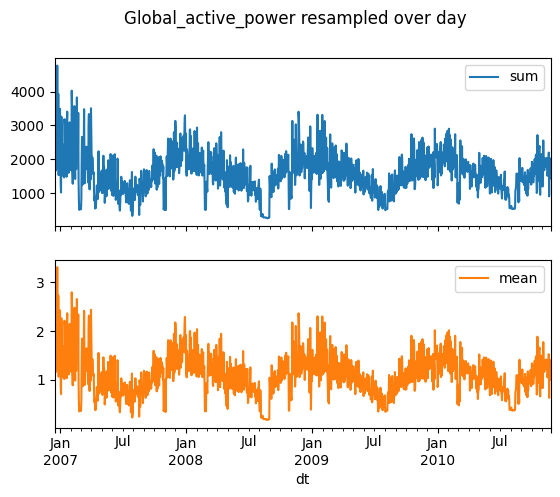

In [6]:
Global_active_power = df.Global_active_power.resample('D').agg(['sum', 'mean'])
Global_active_power.plot(subplots = True, title='Global_active_power resampled over day')
plt.show()

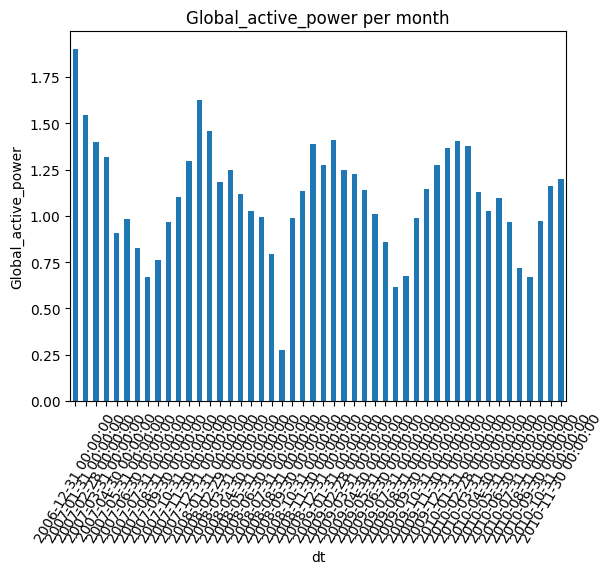

In [7]:
df['Global_active_power'].resample('ME').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per month')
plt.show()

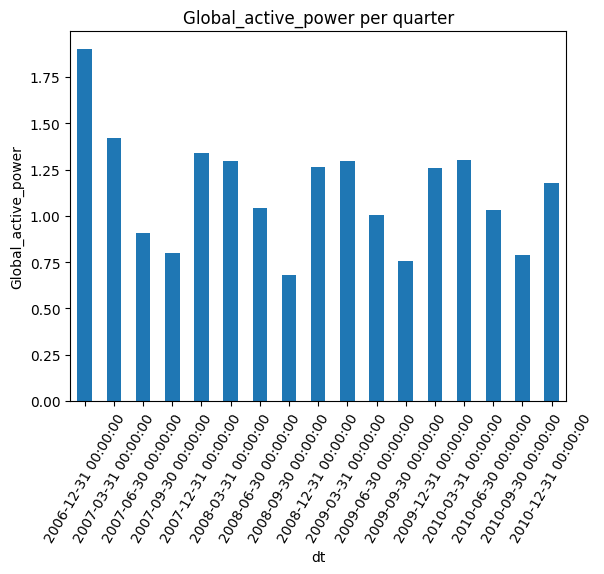

In [8]:
df['Global_active_power'].resample('QE').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per quarter')
plt.show()

Seasonal Trends: The daily, monthly, and quarterly resampling plots reveal seasonal patterns in Global_active_power, with certain months and quarters showing higher energy usage, likely indicating seasonal demand changes.

Downward Trend: The mean daily plot suggests a gradual decrease in average energy consumption over time, possibly reflecting energy-saving efforts or increased efficiency.

### Daily Average of Key Electrical Measurements

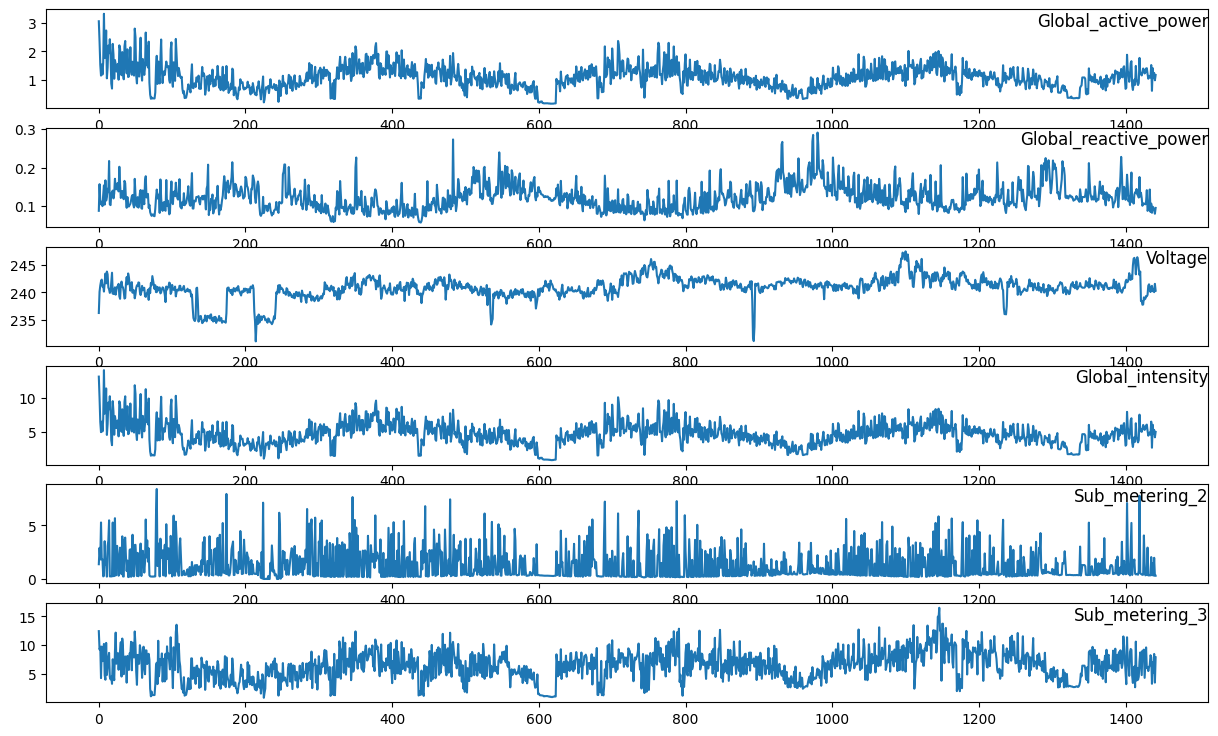

In [69]:
cols = [0, 1, 2, 3, 5, 6]
i = 1
groups = cols
values = df.resample('D').mean().values

plt.figure(figsize=(15, 9))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

There are some irregular drops and spikes across the different measurements, particularly in Voltage and Sub Metering values.

### Weekly Trends in Electrical Consumption and Intensity

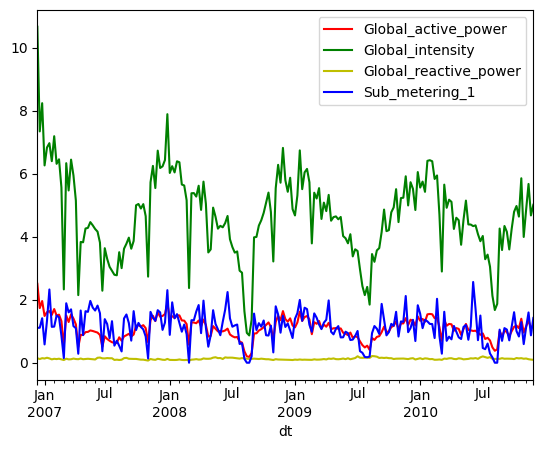

In [14]:
df.Global_active_power.resample('W').mean().plot(color='r', legend=True)
df.Global_intensity.resample('W').mean().plot(color='g', legend=True)
df.Global_reactive_power.resample('W').mean().plot(color='y', legend=True)
df.Sub_metering_1.resample('W').mean().plot(color='b', legend=True)
plt.show()

### Monthly Trends in Power Consumption and Intensity

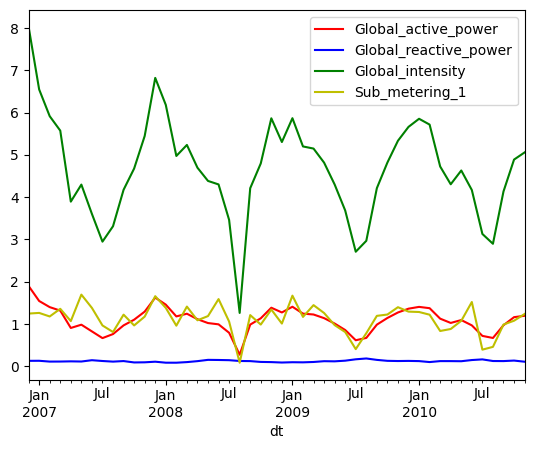

In [15]:
df.Global_active_power.resample('ME').mean().plot(color='r', legend=True )
df.Global_reactive_power.resample('ME').mean().plot(color='b', legend=True)
#df.Voltage.resample('ME').mean().plot(color='g', legend=True)
df.Global_intensity.resample('ME').mean().plot(color='g', legend=True)
df.Sub_metering_1.resample('ME').mean().plot(color='y', legend=True)
plt.show()

Global Intensity shows strong patterns in weekly and monthly plots

Sub Metering values could serve as features in a model might improve its ability to predict peak demand or classify types of energy use.

# Correlation between features

### Global Intensity vs. Global Active Power

Correlation between Global_intensity and Global_active_power: 0.9988886002095887


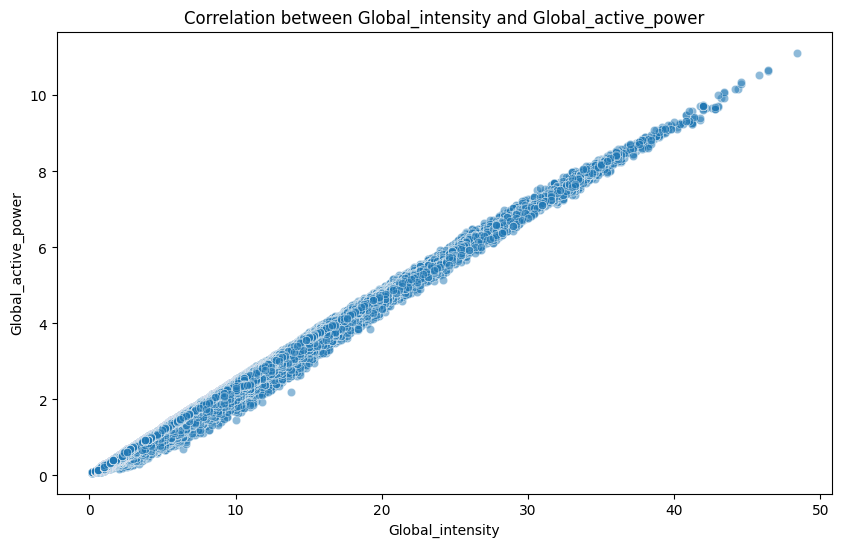

In [17]:
correlation = df['Global_intensity'].corr(df['Global_active_power'])
print(f"Correlation between Global_intensity and Global_active_power: {correlation}") 

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Global_intensity', y='Global_active_power', data=df, alpha=0.5)
plt.title('Correlation between Global_intensity and Global_active_power')
plt.xlabel('Global_intensity')
plt.ylabel('Global_active_power')
plt.show()

Strong linear correlation between Global_intensity and Global_active_power

### Voltage vs. Global Active Power

Correlation between Global_intensity and Global_active_power: -0.39976160962895946


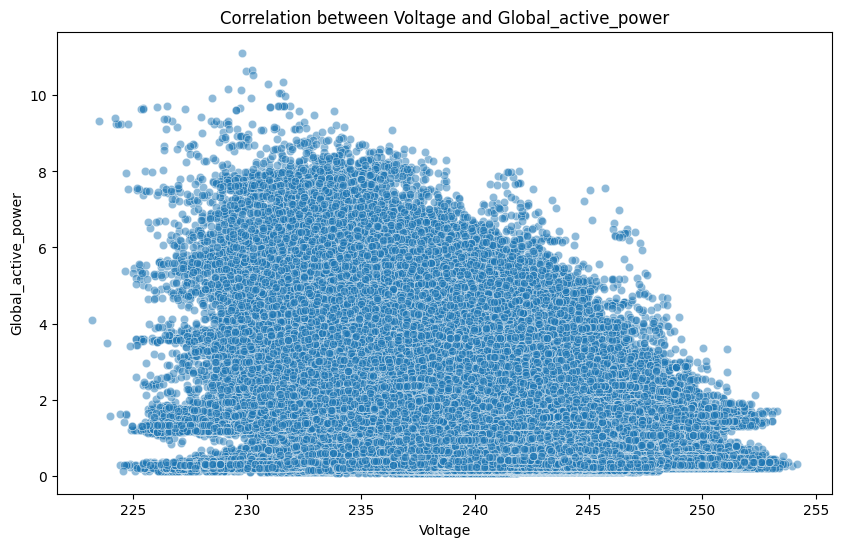

In [19]:
correlation = df['Voltage'].corr(df['Global_active_power'])

print(f"Correlation between Global_intensity and Global_active_power: {correlation}") 

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Voltage', y='Global_active_power', data=df, alpha=0.5)
plt.title('Correlation between Voltage and Global_active_power')
plt.xlabel('Voltage')
plt.ylabel('Global_active_power')
plt.show()

No clear correlation between Voltage and Global_active_power

### Correlations among columns

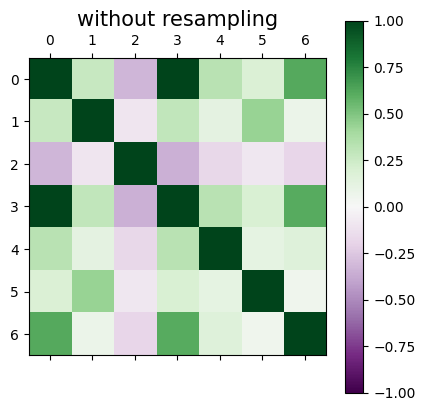

In [20]:
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

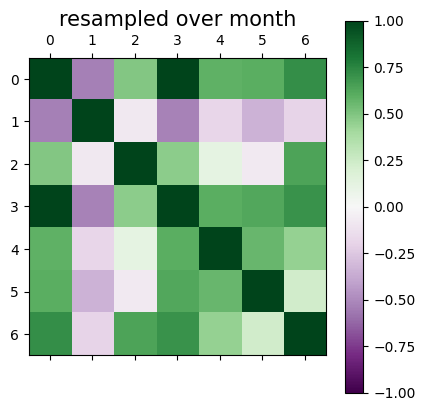

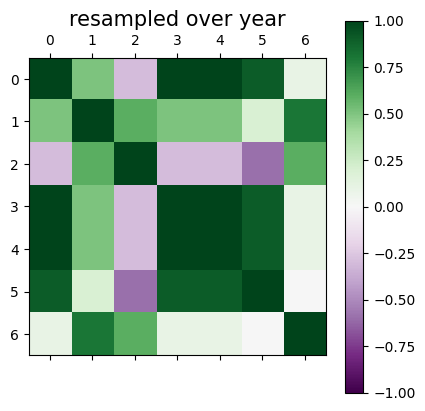

In [21]:
plt.matshow(df.resample('ME').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(df.resample('YE').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()

Resampling techniques can change the correlations among features.

# Prepare data for model

In [7]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [8]:
df_resample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


### Normalize data

In [9]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_resample)

### Split data

In [10]:
train_size = int(0.7 * len(scaled_data))
dev_size = int(0.15 * len(scaled_data))
test_size = len(scaled_data) - train_size - dev_size

train_data = scaled_data[:train_size]
dev_data = scaled_data[train_size:train_size + dev_size]
test_data = scaled_data[train_size + dev_size:]

print("Train data shape:", train_data.shape)
print("Dev data shape:", dev_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (24212, 7)
Dev data shape: (5188, 7)
Test data shape: (5189, 7)


### Create Sliding Windows

In [11]:
window_size = 16 

def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size):
        windows.append(data[i:i+window_size])
    return np.array(windows)

train_windows = create_windows(train_data, window_size)
validation_windows = create_windows(dev_data, window_size)
test_windows = create_windows(test_data, window_size)

print("Train windows shape:", train_windows.shape)
print("Dev windows shape:", validation_windows.shape)
print("Test windows shape:", test_windows.shape)

Train windows shape: (24196, 16, 7)
Dev windows shape: (5172, 16, 7)
Test windows shape: (5173, 16, 7)


In [13]:
train_windows = torch.tensor(train_windows, dtype=torch.float32).to(device)
validation_windows = torch.tensor(validation_windows, dtype=torch.float32).to(device)
test_windows = torch.tensor(test_windows, dtype=torch.float32).to(device)

print("Train windows tensor shape:", train_windows.shape)
print("Validation windows tensor shape:", validation_windows.shape)
print("Test windows tensor shape:", test_windows.shape)

Train windows tensor shape: torch.Size([24196, 16, 7])
Validation windows tensor shape: torch.Size([5172, 16, 7])
Test windows tensor shape: torch.Size([5173, 16, 7])


# Method Description

- Use a VAE (Variational Autoencoder) model to encapsulate local information from a short time window into a low-dimensional embedding.
- Use an LSTM (Long Short-Term Memory) model to process these low-dimensional embeddings from the VAE, capturing sequential patterns over an extended period.

**How it works:** The VAE-LSTM model detects anomalies over a sequence of \( k \) consecutive windows in a given time series. Each window \( w_i \) (the \( i \)-th window) is encoded into a low-dimensional embedding \( e_i \), which is then fed into the LSTM model to predict the embedding for the next window, \( \hat{e}_{i+1} \). This predicted embedding is decoded to reconstruct the original next window \( \hat{w}_{i+1} \). The reconstruction error between the actual and predicted windows serves as the anomaly detection score.

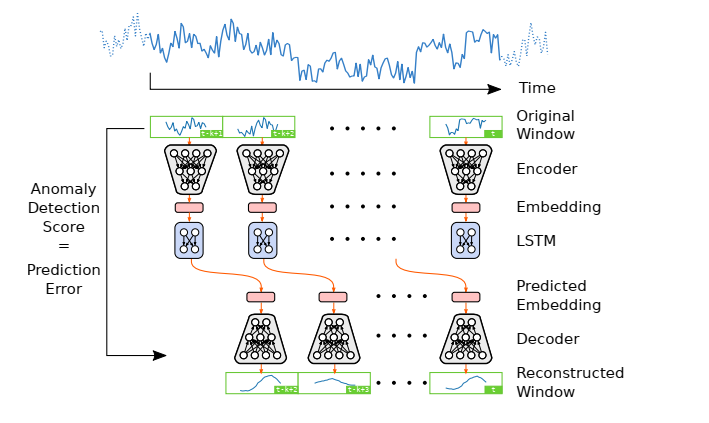

### Variational Autoencoder (VAE) Architecture

The VAE model consists of two primary parts: the Encoder and the Decoder.

- **Encoder:** The encoder compresses the input data into a lower-dimensional latent space, represented by a mean vector and a log variance vector. The encoder has the following layers:
  - `fc1`: A fully connected layer
  - `fc_hidden`: An additional fully connected layer
  - `dropout`: A dropout layer with a 30% drop rate.
  - `fc_mu` and `fc_logvar`: Two separate fully connected layers that produce the mean and log variance vectors of the latent distribution.

- **Reparameterization:** a random noise term is scaled by the standard deviation to create a sampled latent vector \( z \).

- **Decoder:** The decoder reconstructs the original input from the latent vector \( z \). It has the following layers:
  - `fc2`: A fully connected layer.
  - `fc_hidden_dec`: Another fully connected layer.
  - `fc3`: A fully connected layer with a sigmoid activation to output the reconstructed data.

The model's forward pass involves encoding the input to obtain mu and log(sigma^2), reparameterizing to sample \( z \), and then decoding \( z \) to reconstruct the input.

In [14]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim) 
        self.dropout = nn.Dropout(0.3)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc_hidden_dec = nn.Linear(hidden_dim, hidden_dim) 
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.ln1(self.fc1(x)))
        h = torch.relu(self.fc_hidden(h))  
        h = self.dropout(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.ln2(self.fc2(z)))
        h = torch.relu(self.fc_hidden_dec(h))  
        h = self.dropout(h)
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### LSTM Model Architecture

This LSTM model architecture combines layers for sequence processing, normalization, regularization, and a fully connected layer for final output.

- **Bidirectional LSTM Layer:** The model uses a bidirectional LSTM layer with a specified `input_size`, `hidden_size`, and `num_layers`. A `dropout` of 0.3 is applied within the LSTM for regularization.
  
- **Layer Normalization:** A LayerNorm layer is applied on the hidden state outputs of the LSTM.
  
- **Dropout Layer:** `Dropout` layer with a dropout probability of 0.3.
  
- **Fully Connected Layer:** A final fully connected layer. 

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.3)
        self.ln = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size * 2, output_size)  

    def forward(self, x):
        h, _ = self.lstm(x)
        h = self.ln(h)  
        h = self.dropout(h)
        h = self.fc(h)

        return h

# Training and Evaluation Process

#### Anomaly Score Calculation

Anomaly scores are calculated by measuring the reconstruction error over the next window prediction. The procedure for calculating anomaly scores is as follows:

1. **Encoding and Decoding:** 
   - For each input window \( w_i \) with size k, encode k - 1 element to a low-dimensional embedding \( e_i \) using the VAE.
   - Feed \( e_i \) to the LSTM model to predict the embedding for k - 1 element \( \hat{e}_{i} \).
   - Decode \( \hat{e}_{i} \) to reconstruct the original next window \( \hat{w}_{i} \).

2. **Anomaly Score Calculation:**
   - Calculate the anomaly score as the sum of the L2 norm differences between each element from 2 to k in \( w_{i} \) (actual) and from 1 to k - 1 in \( \hat{w}_{i} \) (predicted). 
   - An anomaly is flagged if this score exceeds a defined threshold.

In [ ]:
def calculate_anomaly_scores(vae, lstm, data_windows, threshold):
    anomalies_indices = []
    anomalies_scores = []

    vae.eval()
    lstm.eval()

    with torch.no_grad():
        for i, window in enumerate(data_windows):
            window = window.to(device)
            
            embedding, _ = vae.encode(window[:-1])
            lstm_output = lstm(embedding)
            next_window = vae.decode(lstm_output)
            
            anomaly_score = 0
            for j in range(len(next_window)):
                diff = next_window[j] - window[j + 1]
                l2_norm = torch.sqrt(torch.sum(diff ** 2))
                anomaly_score += l2_norm
                
            anomaly_score = anomaly_score.item()
            
            if anomaly_score > threshold:
                anomalies_indices.append(i)
                anomalies_scores.append(anomaly_score)

            del window, embedding, lstm_output, next_window
            torch.cuda.empty_cache()

    return anomalies_indices, anomalies_scores

#### Training and Loss Functions

The VAE and LSTM components of the model each have specific loss functions:

- **VAE Loss:** The VAE loss consists of two parts:
  - **Reconstruction Loss:** Measures the difference between the reconstructed output and the original input. Here, use L1 loss for this measure.
  - **KLD Loss:** This term encourages the latent space to follow a normal distribution. It is calculated as:
    \[
    -0.5 \sum \left( 1 + \text{logvar} - \mu^2 - \exp(\text{logvar}) \right)
    \]

- **LSTM Loss:** The LSTM loss is the reconstruction loss between the predicted next window embedding \( \hat{e}_{i+1} \) and the actual next window embedding \( e_{i+1} \).


In [ ]:
def train_and_evaluate(latent_dim, hidden_dim, lr):
    # Reconstruction loss function
    def reconstruction_loss_fn(x_recon, x):
        return torch.nn.functional.l1_loss(x_recon, x)

    vae = VAE(input_dim=train_windows.shape[2], hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
    lstm = LSTM(input_size=latent_dim, hidden_size=hidden_dim, num_layers=2, output_size=latent_dim).to(device)
    
    optimizer_vae = torch.optim.Adam(vae.parameters(), lr=lr)
    optimizer_lstm = torch.optim.Adam(lstm.parameters(), lr=lr)

    vae_losses = []
    lstm_losses = []

    for epoch in range(num_epochs):
        vae.train()
        lstm.train()
        total_vae_loss, total_lstm_loss = 0, 0

        with tqdm(total=len(train_windows) - 1, desc=f"Epoch [{epoch+1}/{num_epochs}]") as pbar:
            for i in range(len(train_windows) - 1):
                window = train_windows[i]
                next_window = train_windows[i + 1]
                
                # VAE loss
                x_recon, mu, logvar = vae(window)
                recon_loss = reconstruction_loss_fn(x_recon, window)
                kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                vae_loss = recon_loss + kld_loss

                optimizer_vae.zero_grad()
                vae_loss.backward()
                optimizer_vae.step()
                
                #LSTM loss
                with torch.no_grad():
                    embedding, _ = vae.encode(window)

                lstm_output = lstm(embedding) 
                next_window_embedding, _ = vae.encode(next_window) 
                lstm_loss = reconstruction_loss_fn(lstm_output, next_window_embedding)
                
                optimizer_lstm.zero_grad()
                lstm_loss.backward()
                optimizer_lstm.step()

                total_vae_loss += vae_loss.item()
                total_lstm_loss += lstm_loss.item()

                pbar.set_postfix({"VAE Loss": vae_loss.item(), "LSTM Loss": lstm_loss.item()})
                pbar.update(1)

                del x_recon, mu, logvar, embedding, lstm_output, next_window_embedding
                torch.cuda.empty_cache()

        vae_losses.append(total_vae_loss / len(train_windows))
        lstm_losses.append(total_lstm_loss / (len(train_windows) - 1))

        torch.cuda.empty_cache()

    anomalies_indices, anomaly_scores = calculate_anomaly_scores(vae, lstm, validation_windows, 0.05)
    mean_anomaly_score = np.mean(anomaly_scores)

    torch.cuda.empty_cache()

    return mean_anomaly_score, vae_losses, lstm_losses, vae, lstm

#### Grid Search for Hyperparameter Tuning

A grid search is conducted over different values for `latent_dim`, `hidden_dim`, and `learning_rate` to identify the optimal set of hyperparameters. The goal is to find the combination that results in the lowest mean anomaly score, which indicates the best model performance.

For each combination of hyperparameters:
1. The `train_and_evaluate` function is called to train the VAE and LSTM models.
2. The anomaly score for the validation set is computed.
3. If the anomaly score of the current model is lower than the best score tracked so far, the current parameters and models are saved as the best configuration.

In [17]:
# Hyperparameter
latent_dims = [16, 32]
hidden_dims = [32, 64]
learning_rates = [0.001]
num_epochs = 3

best_score = float('inf')
best_params = {}
best_vae = None
best_lstm = None

all_vae_losses = {}
all_lstm_losses = {}

for latent_dim, hidden_dim, lr in itertools.product(latent_dims, hidden_dims, learning_rates):
    print(f"Testing configuration: Latent Dim={latent_dim}, Hidden Dim={hidden_dim}, LR={lr}")
    mean_anomaly_score, vae_losses, lstm_losses, vae, lstm = train_and_evaluate(latent_dim, hidden_dim, lr)
    
    if mean_anomaly_score < best_score:
        best_score = mean_anomaly_score
        best_params = {'latent_dim': latent_dim, 'hidden_dim': hidden_dim, 'lr': lr}
        best_vae = vae
        best_lstm = lstm

    all_vae_losses[(latent_dim, hidden_dim, lr)] = vae_losses
    all_lstm_losses[(latent_dim, hidden_dim, lr)] = lstm_losses

print("Best hyperparameters:", best_params)
print("Lowest Mean Anomaly Score:", best_score)

Testing configuration: Latent Dim=16, Hidden Dim=32, LR=0.001


Epoch [3/3]: 100%|██████████| 24195/24195 [04:14<00:00, 95.22it/s, VAE Loss=0.0845, LSTM Loss=8.22e-5] 


Testing configuration: Latent Dim=16, Hidden Dim=64, LR=0.001


Epoch [3/3]: 100%|██████████| 24195/24195 [04:13<00:00, 95.29it/s, VAE Loss=0.0845, LSTM Loss=8.19e-5] 


Testing configuration: Latent Dim=32, Hidden Dim=32, LR=0.001


Epoch [3/3]: 100%|██████████| 24195/24195 [03:40<00:00, 109.69it/s, VAE Loss=0.0847, LSTM Loss=0.000159]


Testing configuration: Latent Dim=32, Hidden Dim=64, LR=0.001


Epoch [3/3]: 100%|██████████| 24195/24195 [04:13<00:00, 95.38it/s, VAE Loss=0.0841, LSTM Loss=0.000126]


Best hyperparameters: {'latent_dim': 32, 'hidden_dim': 64, 'lr': 0.001}
Lowest Mean Anomaly Score: 6.952531032016457


### Visualization of Training Losses for Best Hyperparameters

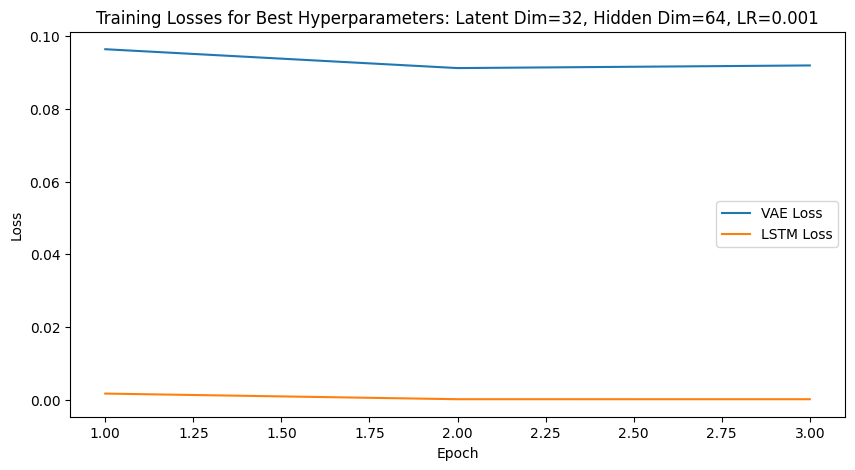

In [18]:
best_hyperparams = (best_params['latent_dim'], best_params['hidden_dim'], best_params['lr'])

vae_losses = all_vae_losses[best_hyperparams]
lstm_losses = all_lstm_losses[best_hyperparams]

plt.figure(figsize=(10, 5))
epochs = range(1, len(vae_losses) + 1)

plt.plot(epochs, vae_losses, label='VAE Loss')
plt.plot(epochs, lstm_losses, label='LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"Training Losses for Best Hyperparameters: Latent Dim={best_params['latent_dim']}, "
          f"Hidden Dim={best_params['hidden_dim']}, LR={best_params['lr']}")
plt.legend()
plt.show()

### Threshold Selection for Anomaly Detection

To effectively identify anomalies, two threshold selection methods are used based on the distribution of anomaly scores:

1. **Percentile-based Threshold**: This method selects a threshold at a specified percentile (e.g., 95th percentile) of the anomaly scores, capturing the highest scoring anomalies.

2. **Mean and Standard Deviation Threshold**: This method calculates the threshold as the mean of anomaly scores plus a multiple \( k \) of the standard deviation (e.g., \( \text{mean} + 3 \times \text{std} \)).

Threshold based on 95th percentile: 11.071438646316528
Threshold based on Mean + 3*Standard Deviation: 13.919479064128817


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


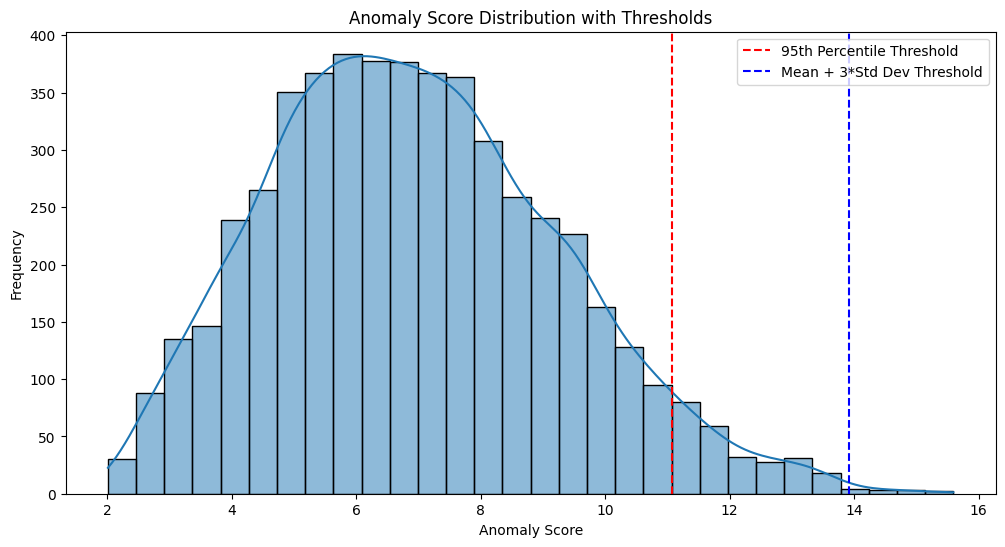

In [19]:
anomalies_validation_indices, anomaly_scores = calculate_anomaly_scores(best_vae, best_lstm, validation_windows, 0.05)

percentile = 95
threshold_percentile = np.percentile(anomaly_scores, percentile)
print(f"Threshold based on {percentile}th percentile: {threshold_percentile}")

mean_score = np.mean(anomaly_scores)
std_score = np.std(anomaly_scores)
k = 3
threshold_mean_std = mean_score + k * std_score
print(f"Threshold based on Mean + {k}*Standard Deviation: {threshold_mean_std}")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(anomaly_scores, bins=30, kde=True)
plt.axvline(threshold_percentile, color='red', linestyle='--', label=f"{percentile}th Percentile Threshold")
plt.axvline(threshold_mean_std, color='blue', linestyle='--', label=f"Mean + {k}*Std Dev Threshold")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Anomaly Score Distribution with Thresholds")
plt.legend()
plt.show()

### Visualize Anomalies and Model Performance on Test set

Detected anomalies at indices: [179, 180, 181, 182, 183, 421, 467, 468, 469, 470, 660, 661, 662, 4116, 4117, 4235, 4236, 4237, 4238, 4239, 4240, 4241, 4527, 4528, 4529]


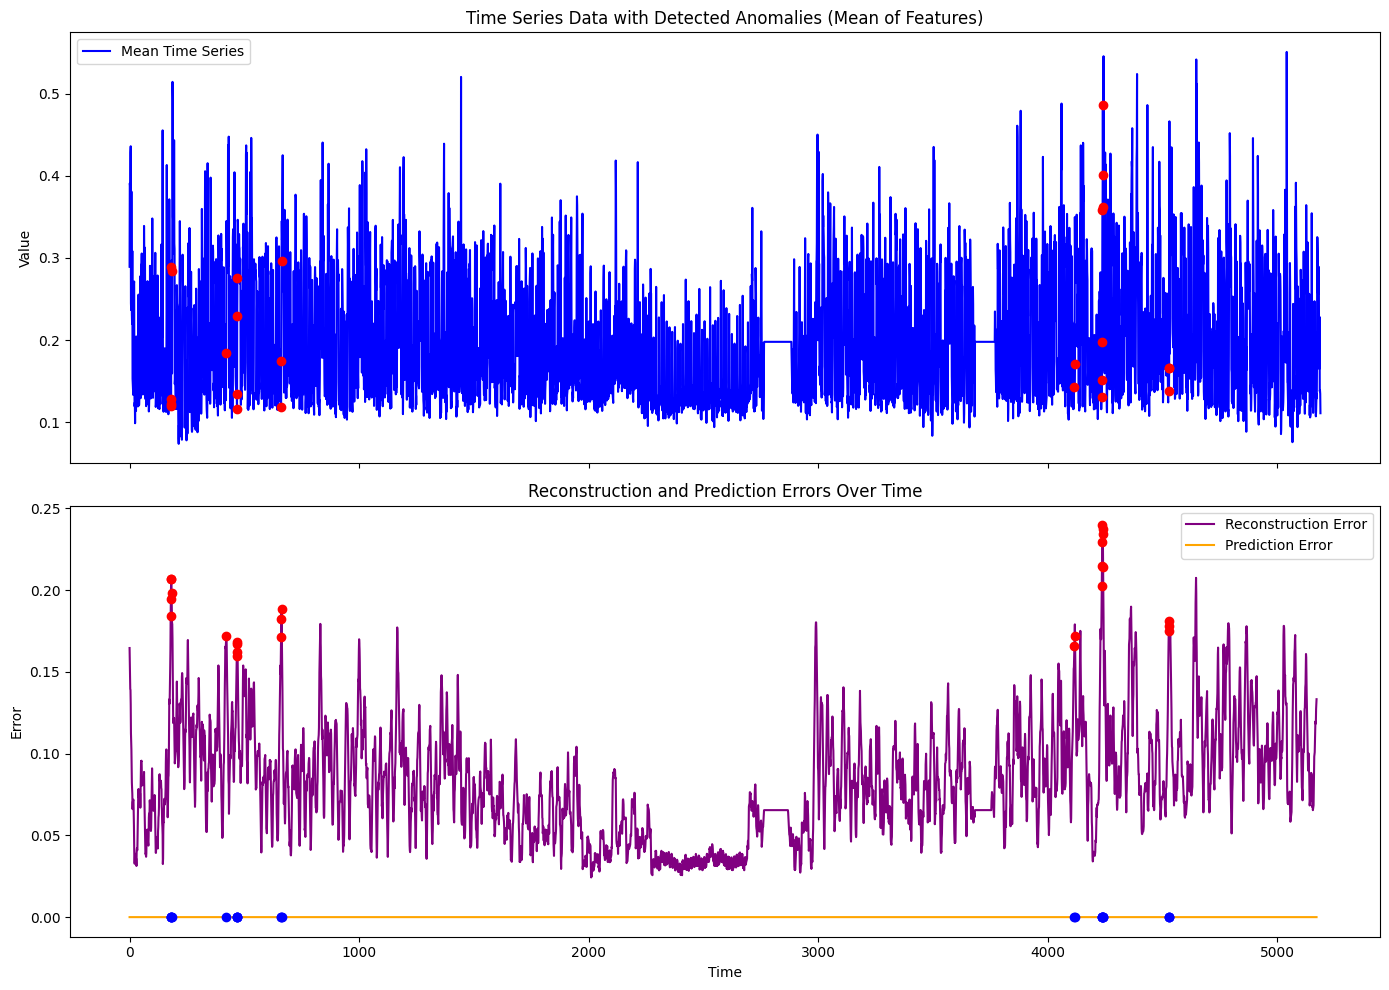

In [23]:
test_data_mean = test_data.mean(axis=1)

final_threshold = threshold_percentile

anomaly_id, anomaly_scores = calculate_anomaly_scores(best_vae, best_lstm, test_windows, final_threshold)
print(f"Detected anomalies at indices: {anomaly_id}")

anomaly_points = [test_data[i].mean() for i in anomaly_id]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax1.plot(range(len(test_data_mean)), test_data_mean, label="Mean Time Series", color='blue')  
for anomaly, point in zip(anomaly_id, anomaly_points):
    ax1.plot(anomaly, point, 'ro') 

ax1.set_ylabel("Value")
ax1.set_title("Time Series Data with Detected Anomalies (Mean of Features)")
ax1.legend()

def reconstruction_loss_fn(x_recon, x):
    return torch.nn.functional.l1_loss(x_recon, x)

reconstruction_errors = []
prediction_errors = []

with torch.no_grad():
    for i, window in enumerate(test_windows[:-1]):
        next_window = test_windows[i + 1]
        
        x_recon, _, _ = best_vae(window)
        recon_error = reconstruction_loss_fn(x_recon, window)
        
        embedding, _ = best_vae.encode(window)
        lstm_output = best_lstm(embedding)
        next_window_embedding, _ = best_vae.encode(next_window)
        prediction_error = reconstruction_loss_fn(lstm_output, next_window_embedding)

        reconstruction_errors.append(recon_error.item())  
        prediction_errors.append(prediction_error.item())

ax2.plot(reconstruction_errors, label="Reconstruction Error", color='purple')
ax2.plot(prediction_errors, label="Prediction Error", color='orange')
for anomaly in anomaly_id:
    ax2.plot(anomaly, reconstruction_errors[anomaly], 'ro') 
    
for anomaly in anomaly_id:
    ax2.plot(anomaly, prediction_errors[anomaly], 'bo')  

ax2.set_xlabel("Time")
ax2.set_ylabel("Error")
ax2.legend()
ax2.set_title("Reconstruction and Prediction Errors Over Time")

plt.tight_layout()
plt.show()

### Error Analysis for Normal and Anomalous Data

      Type      Error Type  Mean Error  Standard Deviation
0   Normal  Reconstruction    0.081962            0.033368
1  Anomaly  Reconstruction    0.192228            0.024428
2   Normal      Prediction    0.000105            0.000000
3  Anomaly      Prediction    0.000105            0.000000


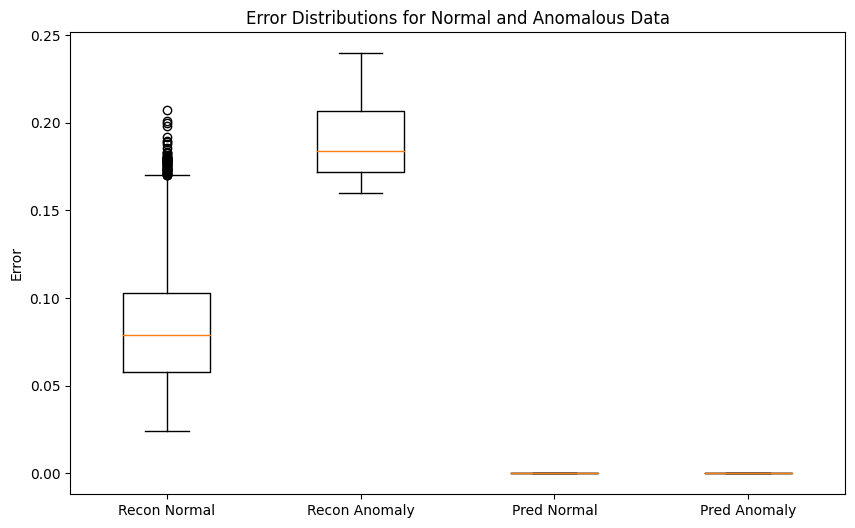

In [24]:
recon_errors_anomalies = [reconstruction_errors[i] for i in anomaly_id]
pred_errors_anomalies = [prediction_errors[i] for i in anomaly_id]
recon_errors_normal = [reconstruction_errors[i] for i in range(len(reconstruction_errors)) if i not in anomaly_id]
pred_errors_normal = [prediction_errors[i] for i in range(len(prediction_errors)) if i not in anomaly_id]

error_data = {
    "Type": ["Normal", "Anomaly", "Normal", "Anomaly"],
    "Error Type": ["Reconstruction", "Reconstruction", "Prediction", "Prediction"],
    "Mean Error": [
        np.mean(recon_errors_normal), np.mean(recon_errors_anomalies),
        np.mean(pred_errors_normal), np.mean(pred_errors_anomalies)
    ],
    "Standard Deviation": [
        np.std(recon_errors_normal), np.std(recon_errors_anomalies),
        np.std(pred_errors_normal), np.std(pred_errors_anomalies)
    ]
}
error_df = pd.DataFrame(error_data)
print(error_df)

plt.figure(figsize=(10, 6))
plt.boxplot([recon_errors_normal, recon_errors_anomalies, pred_errors_normal, pred_errors_anomalies],
            labels=["Recon Normal", "Recon Anomaly", "Pred Normal", "Pred Anomaly"])
plt.title("Error Distributions for Normal and Anomalous Data")
plt.ylabel("Error")
plt.show()

# Generating Explanations Using LLM

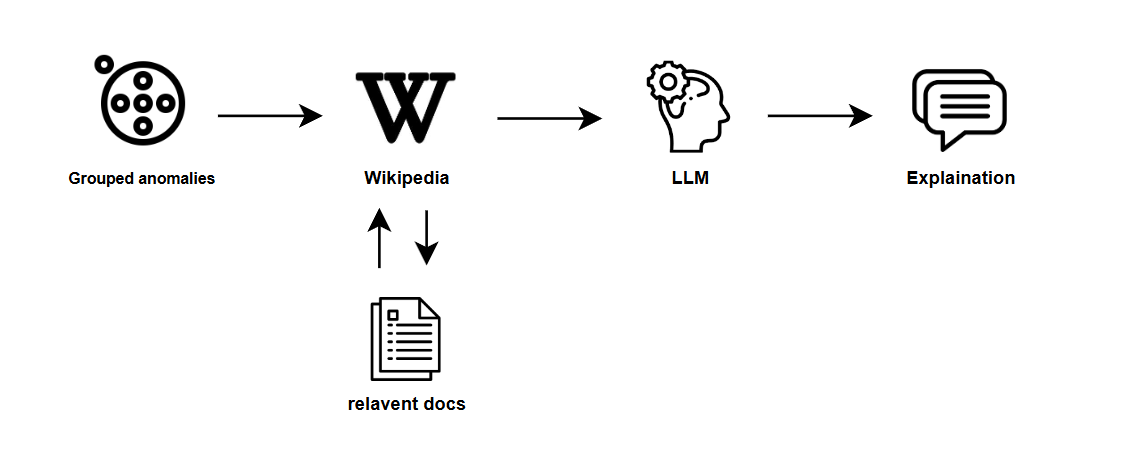

### Grouping Consecutive Anomalies

In [25]:
def group_anomalies(anomalies, gap=1):
    grouped_anomalies = []
    current_group = [anomalies[0]]
    
    for i in range(1, len(anomalies)):
        if anomalies[i] <= current_group[-1] + gap:  
            current_group.append(anomalies[i])
        else:
            grouped_anomalies.append(current_group)
            current_group = [anomalies[i]]
    
    grouped_anomalies.append(current_group)
    
    return grouped_anomalies

grouped_anomalies = group_anomalies(anomaly_id)
print(f"Grouped anomalies: {grouped_anomalies}")

Grouped anomalies: [[179, 180, 181, 182, 183], [421], [467, 468, 469, 470], [660, 661, 662], [4116, 4117], [4235, 4236, 4237, 4238, 4239, 4240, 4241], [4527, 4528, 4529]]


### Feature-wise Anomaly Scoring

In [50]:
def calculate_feature_anomaly_scores(vae, lstm, window, threshold, feature_names):
    embedding, _ = vae.encode(window[:-1])  
    lstm_output = lstm(embedding)
    next_window = vae.decode(lstm_output)

    scores = torch.mean(abs(next_window - window[1:]), dim=0) 

    feature_scores = {feature_names[i]: scores[i].item() for i in range(len(feature_names))}

    return feature_scores

### Wikipedia Search for Anomaly Explanation

Generates a Wikipedia search query based on anomaly feature scores, aiming to retrieve relevant information that may help in explaining the anomaly.

In [28]:
def search_wikipedia(feature_scores):
    search_query = "Energy consumption anomaly explanation. High scores in features:\n"
    for feature_name, score in feature_scores.items():
        search_query += f"{feature_name}: {score}\n"

    wiki_search_url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "list": "search",
        "srsearch": search_query,
        "format": "json",
        "srlimit": 3  
    }

    response = requests.get(wiki_search_url, params=params)
    
    if response.status_code == 200:
        search_results = response.json().get("query", {}).get("search", [])
        relevant_docs = [result['snippet'] for result in search_results]
    else:
        relevant_docs = []

    return relevant_docs

### Generating Explanations Using Groq API

In [29]:
def generate_explanation_groq(feature_scores, relevant_docs):
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("GROQ_API_KEY")

    client = Groq(api_key=api_key)

    prompt = (
        "You are an AI system explaining anomaly detection in energy consumption. "
        "The anomaly scores for different features are:\n"
    )
    for feature_name, score in feature_scores.items():
        prompt += f"{feature_name}: {score}\n"
    
    prompt += "\nBased on the following information from Wikipedia, explain possible reasons for this anomaly:\n"
    for doc in relevant_docs:
        prompt += f"Document: {doc}\n"
    
    prompt += "Provide a clear and concise explanation for this anomaly."

    chat_completion = client.chat.completions.create(
        messages=[
            {"role": "system", "content": "You are an AI assistant that helps explain anomaly detection in energy consumption."},
            {"role": "user", "content": prompt}
        ],
        model="llama3-8b-8192",
    )

    explanation_text = chat_completion.choices[0].message.content
    return explanation_text

### Explaining Anomalies for Grouped Data

In [51]:
def explain_anomalies_for_groups(vae, lstm, test_data, test_windows, grouped_anomalies, threshold, feature_names):
    all_explanations = []
    
    for idx, group in enumerate(grouped_anomalies, start=1):
        group_windows = [test_windows[i] for i in group]
        avg_window = torch.mean(torch.stack(group_windows), dim=0)

        feature_scores = calculate_feature_anomaly_scores(vae, lstm, avg_window, threshold, feature_names)

        relevant_docs = search_wikipedia(feature_scores)

        explanation_text = generate_explanation_groq(feature_scores, relevant_docs)
        all_explanations.append((group, explanation_text))

        print(f"\n{'='*117}")
        print(f"** Explanation for Anomaly Group {idx} (Indices: {group}) **")
        print(f"{'='*117}")
        print(explanation_text)
        print(f"{'='*117}\n")
    
    return all_explanations

In [52]:
feature_names = df_resample.columns.tolist() 

anomaly_explanations_grouped = explain_anomalies_for_groups(
    best_vae, best_lstm, test_data, test_windows, grouped_anomalies, final_threshold, feature_names
)


** Explanation for Anomaly Group 1 (Indices: [179, 180, 181, 182, 183]) **
Anomaly detection in energy consumption is the process of identifying unusual patterns or outliers in energy usage data. Based on the anomaly scores provided, it appears that there are several features in the energy consumption dataset that have high anomaly scores.

According to Wikipedia, anomaly detection in energy consumption can be caused by various factors, including:

1. Changes in usage patterns: An unusual change in energy usage patterns, such as a sudden increase or decrease in energy consumption, can be detected as an anomaly.
2. Equipment failure: A failure or malfunction of energy-using equipment, such as a heating or cooling system, can cause unusual energy usage patterns.
3. Seasonal variations: Seasonal changes, such as colder winters or hotter summers, can cause changes in energy consumption patterns.
4. Utility grid issues: Problems with the utility grid, such as power outages or electrical su

# Testing the Anomaly Detection and Explanation Pipeline

### Creating Synthetic Test Data with Anomalies

In [70]:
def create_data_with_anomalies(num_rows=1000, anomaly_ratio=0.05):
    dates = pd.date_range("2006-12-16 17:24:00", periods=num_rows, freq="T")
    data = {
        "Date": dates.strftime("%d/%m/%Y"),
        "Time": dates.strftime("%H:%M:%S"),
        "Global_active_power": np.random.normal(4, 0.5, num_rows),
        "Global_reactive_power": np.random.normal(0.4, 0.05, num_rows),
        "Voltage": np.random.normal(235, 1, num_rows),
        "Global_intensity": np.random.normal(18, 2, num_rows),
        "Sub_metering_1": np.random.normal(1, 0.5, num_rows),
        "Sub_metering_2": np.random.normal(1, 0.5, num_rows),
        "Sub_metering_3": np.random.normal(17, 2, num_rows),
    }

    df = pd.DataFrame(data)

    num_anomalies = int(num_rows * anomaly_ratio)
    anomaly_indices = np.random.choice(df.index, num_anomalies, replace=False)

    df.loc[anomaly_indices, "Global_active_power"] *= np.random.uniform(1.5, 2.5, num_anomalies)
    df.loc[anomaly_indices, "Voltage"] *= np.random.uniform(0.8, 1.2, num_anomalies)
    df.loc[anomaly_indices, "Global_intensity"] *= np.random.uniform(1.5, 2.0, num_anomalies)

    df.to_csv("anomaly_data.csv", sep=';', index=False)

    return df

df_anomaly = create_data_with_anomalies()

/tmp/ipykernel_30/3562259211.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range("2006-12-16 17:24:00", periods=num_rows, freq="T")


### Detecting and Explaining Anomalies in New Data

In [60]:
def explain(new_data_path, vae_model, lstm_model, scaler, window_size, threshold, feature_names):
    df_new = pd.read_csv(new_data_path, sep=';', low_memory=False, na_values=['nan', '?'])
    df_new['dt'] = pd.to_datetime(df_new['Date'] + ' ' + df_new['Time'], format='%d/%m/%Y %H:%M:%S')
    df_new = df_new.set_index('dt')
    df_new = df_new.drop(['Date', 'Time'], axis=1)
    df_new = df_new.fillna(df_new.mean())

    df_resample_new = df_new.resample('h').mean()
    scaled_data_new = scaler.transform(df_resample_new)
 
    new_data_windows = create_windows(scaled_data_new, window_size)
    new_data_windows = torch.tensor(new_data_windows, dtype=torch.float32).to(device)

    anomaly_indices, anomaly_scores = calculate_anomaly_scores(vae_model, lstm_model, new_data_windows, threshold)
    grouped_anomalies = group_anomalies(anomaly_indices)

    explanations = explain_anomalies_for_groups(
        vae_model, lstm_model, scaled_data_new, new_data_windows, grouped_anomalies, threshold, feature_names
    )

In [63]:
explain("/kaggle/working/anomaly_data.csv", best_vae, best_lstm, scaler, window_size, final_threshold, feature_names)


** Explanation for Anomaly Group 1 (Indices: [0, 1]) **
According to Wikipedia, anomaly detection in energy consumption typically involves identifying unusual patterns or behavior in energy usage data that may indicate a fault, malfunction, or unusual activity in the system.

Based on the provided anomaly scores, it appears that the feature 'Global_intensity' has a high anomaly score of 0.5796036720275879, which is significantly higher than the other features.

Possible reasons for this anomaly could be:

* Abnormal wiring or electrical configuration: A high global intensity reading could indicate a faulty or misconfigured electrical connection, leading to unusual power consumption patterns.
* Unusual usage patterns or equipment operation: A specific appliance or device connected to the global intensity circuit is operating abnormally, causing the energy consumption to spike.
* Equipment maintenance or repair: A temporary increase in global intensity is possible when equipment is bein

# References

[1] S. Lin, R. Clark, R. Birke, S. Schönborn, N. Trigoni and S. Roberts, "Anomaly Detection for Time Series Using VAE-LSTM Hybrid Model," ICASSP 2020 - 2020 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), Barcelona, Spain, 2020, pp. 4322-4326, doi: 10.1109/ICASSP40776.2020.9053558. keywords: {Correlation;Time series analysis;Signal processing;Detection algorithms;Speech processing;Anomaly detection;Unsupervised learning;Anomaly Detection;Time Series;Deep Learning;Unsupervised Learning},